<a href="https://colab.research.google.com/github/ssunart/Scripts/blob/main/%5BHomework%5D_Make_prediction_model_no_01_fp2048.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework
 No.01
* 조건01: **fingerprint의 bit 2048**로 늘려서 학습시킨 모델 만들기
* 조건02: **Classification**과 **Regression** 모두 시도해보기

## 1. rdkit 설치 및 하위 모듈 불러오기
---

In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 24.1 MB/s eta 0:00:00


In [2]:
import rdkit
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem

## 2. 추가적으로 사용할 패키지 불러오기
---

* tqdm의 경우 실시간으로 각 프로세스의 진행도를 볼 수 있게 해준다.

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
from tqdm import tqdm # to show a progress bar.

## 3. 모델 제작에 사용할 데이터 가져오기
---
* wget으로 jak2_data.csv 파일을 다운로드 한다.
* colab에서 linux용 cmd 사용시 command 앞에 '!'를 붙여서 사용할 수 있다.

In [4]:
!wget -O jak2_data.csv https://www.dropbox.com/s/322tzexv1e6wcnb/jak2_data.csv?dl=0

--2024-12-18 07:51:52--  https://www.dropbox.com/s/322tzexv1e6wcnb/jak2_data.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/torcspjhgbivzsxl55iix/jak2_data.csv?rlkey=ttf9eqsh19om1yfbg6h2ymxcf&dl=0 [following]
--2024-12-18 07:51:52--  https://www.dropbox.com/scl/fi/torcspjhgbivzsxl55iix/jak2_data.csv?rlkey=ttf9eqsh19om1yfbg6h2ymxcf&dl=0
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce02312a74fa3694c11ca73652b.dl.dropboxusercontent.com/cd/0/inline/CgfeVQSIeah2CcWw2bCpFOKhGm718W6t2LRaQ5vNBY-25aKbKAhReYGoHBX1zPSQLWPJqqE66ivBNLPr88_abAnT0PVXEWnibvx6-eQ0KnqL52aOh8LN_BLjfH-AXzcEsJ6irE6sF02urb87Wjeo5jZL/file# [following]
--2024-12-18 07:51:53--  https://uce02312a74fa3694c11ca73652b.dl.dropboxusercontent

#*Point)*
  하나의 분자가 여러가지 SMILES로 표현됐을 수 있으므로 데이터 중복을 피하기 위해 **canonical SMILES** 로 conversion 시켜즐 것이다.

* SMILES로부터 molecule을 읽어들이고, molecule을 다시 canonical SMILES로 저장하기.
* %%time 은 decorator(*in Python*)로 해당 프로세스의 running time을 출력해준다.

In [5]:
%%time
fout = open("jak2_data_canonical.csv", "w")
fout.write("SMILES,pIC50\n")

with open("jak2_data.csv") as fp:
  l = fp.readline()
  idx = 0
  for l in fp:
    smiles, ic50 = l.strip().split(',')
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: # if not a valid SMILES.
      continue
    new_smi = Chem.MolToSmiles(mol, canonical=True)
    fout.write(f"{new_smi},{ic50}\n")
    idx += 1
print(f"Total number of converted molecules: {idx}")
fout.close()

Total number of converted molecules: 1911
CPU times: user 1.44 s, sys: 7.47 ms, total: 1.45 s
Wall time: 3.11 s


Canonical SMILES로 변환된 정보가 담긴 CSV file 읽어들이기

In [6]:
data = pd.read_csv("jak2_data_canonical.csv") # CSV 파일을 읽어들이자!
data

,SMILES,pIC50
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59
...,...,...
1906,CC(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.72
1907,CN1CCN(c2ncc(-c3cnc4[nH]ccc4n3)c(NC3CCCN(S(=O)...,10.76
1908,CC1CN(S(=O)(=O)CC2CCC(N(C)c3[nH]cnc4nccc3-4)CC...,10.78
1909,CS(=O)(=O)N1CCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.97


## 4. SMILES column을 기준으로 중복인 행을 제거하기
---

* pandas DataFrame의 drop_duplicates라는 method 사용
* keep='first'는 처음 나오는 entry를 유지시킨다는 뜻
* inplace=True는 기존 DataFrame에 바로 적용시킨다는 뜻

In [7]:
data.drop_duplicates(subset="SMILES", keep='first', inplace=True, ignore_index=True)

중복인 행이 제거된 데이터 체크

In [8]:
data.head()

,SMILES,pIC50
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1,4.26
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...,4.34
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO,4.53
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21,4.56
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1,4.59


In [9]:
data.tail()

,SMILES,pIC50
1715,CC(C)CS(=O)(=O)N1CCCC(Nc2nc(N)ncc2-c2cnc3[nH]c...,10.71
1716,CC(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.72
1717,CN1CCN(c2ncc(-c3cnc4[nH]ccc4n3)c(NC3CCCN(S(=O)...,10.76
1718,CC1CN(S(=O)(=O)CC2CCC(N(C)c3[nH]cnc4nccc3-4)CC...,10.78
1719,COC(=O)N1CCCCC(Nc2ncccc2-c2cnc3[nH]ccc3n2)C1,10.97


기존에 Total 1911 molecules에서 1720 molecules로 줄어든 것을 확인할 수 있다.

#*Point)*
describe() 함수를 이용해 각 column의 특징적인 통계값들을 확인할 수 있다.

In [10]:
data.describe()

,pIC50
count,1720.000000
mean,7.350105
std,1.213571
min,4.260000
25%,6.557500
50%,7.340000
75%,8.080000
max,10.970000


#*Point)*
hist() 함수를 이용해 pIC50 분포를 히스토그램으로 확인할 수 있다.

<Axes: >

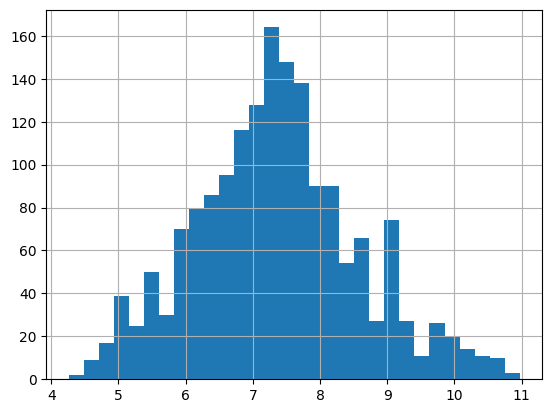

In [11]:
data["pIC50"].hist(bins=30)

## 5. 정리된 SMILES를 mol type 변수로 변경하기
---

In [12]:
%%time
mols = [Chem.MolFromSmiles(x) for x in data["SMILES"]]

CPU times: user 727 ms, sys: 41.8 ms, total: 769 ms
Wall time: 1.17 s


## 6. Mol instance를 feature vector로 변환
---
* 1) Converting mol to fingerprint
> radius = 2, **bit의 개수 = 2048** 로 하여 ECFP로 변환




In [13]:
radius = 2; nbits = 2048
fp_list = []
for m in tqdm(mols):
  fp = AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits=nbits) # if radius = 2, then fp is an ECFP4
  fp_list.append(fp.ToList())

  0%|          | 0/1720 [00:00<?, ?it/s][07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRECATION WARNING: please use MorganGenerator
[07:52:10] DEPRE

변환된 fingerprint 체크

In [14]:
fp_df = pd.DataFrame(fp_list)
fp_df

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1716,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* 2) Fingerprint table을 csv 및 python pickle(.pkl)로 저장한다.

In [15]:
fp_df.to_csv("jak2_fp2048_descriptors.csv")
fp_df.to_pickle("jak2_fp2048_descriptors.pkl")

## 7. RDKit 이용해 molecular descriptors 만들기
---

* 다양한 biophysical & physicochemical property, topological property 등을 숫자화시킨 RDkit 내의 여러가지 함수를 이용해 분자를 표현해보자.

In [16]:
import numpy as np
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.GraphDescriptors import (BalabanJ, BertzCT, Chi0, Chi0n, Chi0v, Chi1,
                                         Chi1n, Chi1v, Chi2n, Chi2v, Chi3n, Chi3v, Chi4n, Chi4v,
                                         HallKierAlpha, Ipc, Kappa1, Kappa2, Kappa3)

from rdkit.Chem.EState.EState_VSA import (EState_VSA1, EState_VSA10, EState_VSA11, EState_VSA2, EState_VSA3,
                                          EState_VSA4, EState_VSA5, EState_VSA6, EState_VSA7, EState_VSA8, EState_VSA9,
                                          VSA_EState1, VSA_EState10, VSA_EState2, VSA_EState3, VSA_EState4, VSA_EState5,
                                          VSA_EState6, VSA_EState7, VSA_EState8, VSA_EState9,)

from rdkit.Chem.Descriptors import (ExactMolWt, MolWt, HeavyAtomMolWt, MaxAbsPartialCharge, MinPartialCharge,
                                    MaxPartialCharge, MinAbsPartialCharge, NumRadicalElectrons, NumValenceElectrons)
from rdkit.Chem.EState.EState import (MaxAbsEStateIndex, MaxEStateIndex, MinAbsEStateIndex, MinEStateIndex,)
from rdkit.Chem.Lipinski import (FractionCSP3, HeavyAtomCount, NHOHCount, NOCount, NumAliphaticCarbocycles,
                                 NumAliphaticHeterocycles, NumAliphaticRings, NumAromaticCarbocycles, NumAromaticHeterocycles,
                                 NumAromaticRings, NumHAcceptors, NumHDonors, NumHeteroatoms, RingCount,
                                 NumRotatableBonds, NumSaturatedCarbocycles, NumSaturatedHeterocycles, NumSaturatedRings,)
from rdkit.Chem.Crippen import (MolLogP, MolMR,)
from rdkit.Chem.MolSurf import (LabuteASA, PEOE_VSA1, PEOE_VSA10, PEOE_VSA11, PEOE_VSA12, PEOE_VSA13, PEOE_VSA14,
                                PEOE_VSA2, PEOE_VSA3,PEOE_VSA4, PEOE_VSA5, PEOE_VSA6, PEOE_VSA7, PEOE_VSA8, PEOE_VSA9,
                                SMR_VSA1, SMR_VSA10, SMR_VSA2, SMR_VSA3, SMR_VSA4, SMR_VSA5, SMR_VSA6,
                                SMR_VSA7, SMR_VSA8, SMR_VSA9, SlogP_VSA1, SlogP_VSA10, SlogP_VSA11, SlogP_VSA12,
                                SlogP_VSA2, SlogP_VSA3,SlogP_VSA4, SlogP_VSA5, SlogP_VSA6, SlogP_VSA7, SlogP_VSA8,
                                SlogP_VSA9, TPSA,)
from rdkit.Chem.Fragments import (fr_Al_COO, fr_Al_OH, fr_Al_OH_noTert, fr_ArN, fr_Ar_COO, fr_Ar_N, fr_Ar_NH,
 fr_Ar_OH, fr_COO, fr_COO2, fr_C_O, fr_C_O_noCOO, fr_C_S, fr_HOCCN, fr_Imine, fr_NH0, fr_NH1,
 fr_NH2, fr_N_O, fr_Ndealkylation1, fr_Ndealkylation2, fr_Nhpyrrole, fr_SH, fr_aldehyde, fr_alkyl_carbamate,
 fr_alkyl_halide, fr_allylic_oxid, fr_amide, fr_amidine, fr_aniline, fr_aryl_methyl, fr_azide, fr_azo, fr_barbitur,
 fr_benzene, fr_benzodiazepine, fr_bicyclic, fr_diazo, fr_dihydropyridine, fr_epoxide, fr_ester, fr_ether, fr_furan,
 fr_guanido, fr_halogen, fr_hdrzine, fr_hdrzone, fr_imidazole, fr_imide, fr_isocyan, fr_isothiocyan, fr_ketone,
 fr_ketone_Topliss, fr_lactam, fr_lactone, fr_methoxy, fr_morpholine, fr_nitrile, fr_nitro, fr_nitro_arom,
 fr_nitro_arom_nonortho, fr_nitroso, fr_oxazole, fr_oxime, fr_para_hydroxylation, fr_phenol,
 fr_phenol_noOrthoHbond, fr_phos_acid, fr_phos_ester, fr_piperdine, fr_piperzine, fr_priamide, fr_prisulfonamd,
 fr_pyridine, fr_quatN, fr_sulfide, fr_sulfonamd, fr_sulfone, fr_term_acetylene, fr_tetrazole, fr_thiazole, fr_thiocyan,
 fr_thiophene, fr_unbrch_alkane, fr_urea)


def calc_rdkit_descriptors(mol):
    AllChem.ComputeGasteigerCharges(mol)
    if np.isnan(MinPartialCharge(mol)):
        print("NaN!", Chem.MolToSmiles(mol))
        descriptors = None
    else:
        descriptors = [
                BalabanJ(mol) , # 0
                0.0001*BertzCT(mol) , # 1
                0.1*Chi0(mol) , # 2
                0.1*Chi0n(mol) , # 3
                0.1*Chi0v(mol) , # 4
                0.1*Chi1(mol) , # 5
                0.1*Chi1n(mol) , # 6
                0.1*Chi1v(mol) , # 7
                0.1*Chi2n(mol) , # 8
                0.1*Chi2v(mol) , # 9
                0.1*Chi3n(mol) , # 10
                0.1*Chi3v(mol) , # 11
                0.1*Chi4n(mol) , # 12
                0.1*Chi4v(mol) , # 13
                0.01*EState_VSA1(mol) , # 14
                0.01*EState_VSA10(mol) , #15
                0.01*EState_VSA11(mol) , #16
                0.01*EState_VSA2(mol) , #17
                0.01*EState_VSA3(mol) , #18
                0.01*EState_VSA4(mol) ,
                0.01*EState_VSA5(mol) , #20
                0.01*EState_VSA6(mol) ,
                0.01*EState_VSA7(mol) ,
                0.01*EState_VSA8(mol) ,
                0.01*EState_VSA9(mol) ,
                0.001*ExactMolWt(mol) , #25
                FractionCSP3(mol) ,
                HallKierAlpha(mol) ,
                0.01*HeavyAtomCount(mol) ,
                0.001*HeavyAtomMolWt(mol) ,
                0.1*Kappa1(mol) , #30
                0.1*Kappa2(mol) ,
                0.001*Kappa3(mol) ,
                0.01*LabuteASA(mol) ,
                0.1*MaxAbsEStateIndex(mol) ,
                MaxAbsPartialCharge(mol) , #35
                0.1*MaxEStateIndex(mol) ,
                MaxPartialCharge(mol) , #37
                MinAbsEStateIndex(mol) ,
                MinAbsPartialCharge(mol) , #39
                MinEStateIndex(mol) , #40
                MinPartialCharge(mol) ,
                0.1*MolLogP(mol) ,
                0.01*MolMR(mol) ,
                0.001*MolWt(mol) ,
                0.1*NHOHCount(mol) , #45
                0.1*NOCount(mol) ,
                NumAliphaticCarbocycles(mol) ,
                NumAliphaticHeterocycles(mol) ,
                0.1*NumAliphaticRings(mol) ,
                NumAromaticCarbocycles(mol) , #50
                NumAromaticHeterocycles(mol) ,
                NumAromaticRings(mol) ,
                0.1*NumHAcceptors(mol) ,
                0.1*NumHDonors(mol) ,
                0.1*NumHeteroatoms(mol) , #55
                NumRadicalElectrons(mol) ,
                0.1*NumRotatableBonds(mol) ,
                NumSaturatedCarbocycles(mol) ,
                NumSaturatedHeterocycles(mol) ,
                0.1*NumSaturatedRings(mol) , #60
                0.01*NumValenceElectrons(mol) ,
                0.01*PEOE_VSA1(mol) ,
                0.01*PEOE_VSA10(mol) ,
                0.01*PEOE_VSA11(mol) ,
                0.01*PEOE_VSA12(mol) , #65
                0.01*PEOE_VSA13(mol) ,
                0.01*PEOE_VSA14(mol) ,
                0.01*PEOE_VSA2(mol) ,
                0.01*PEOE_VSA3(mol) ,
                0.01*PEOE_VSA4(mol) , #70
                0.01*PEOE_VSA5(mol) ,
                0.01*PEOE_VSA6(mol) ,
                0.01*PEOE_VSA7(mol) ,
                0.01*PEOE_VSA8(mol) ,
                0.01*PEOE_VSA9(mol) , # 75
                0.1*RingCount(mol) ,
                0.01*SMR_VSA1(mol) ,
                0.01*SMR_VSA10(mol) ,
                0.01*SMR_VSA2(mol) ,
                0.01*SMR_VSA3(mol) , # 80
                0.01*SMR_VSA4(mol) ,
                0.01*SMR_VSA5(mol) ,
                0.01*SMR_VSA6(mol) ,
                0.01*SMR_VSA7(mol) ,
                0.01*SMR_VSA8(mol) , #85
                0.01*SMR_VSA9(mol) ,
                0.01*SlogP_VSA1(mol) ,
                0.01*SlogP_VSA10(mol) ,
                0.01*SlogP_VSA11(mol) ,
                0.01*SlogP_VSA12(mol) ,#90
                0.01*SlogP_VSA2(mol) , #91
                0.01*SlogP_VSA3(mol) ,
                0.01*SlogP_VSA4(mol) ,
                0.01*SlogP_VSA5(mol) ,
                0.01*SlogP_VSA6(mol) , #95
                0.01*SlogP_VSA7(mol) ,
                0.01*SlogP_VSA8(mol) , #97
                0.01*SlogP_VSA9(mol) ,
                0.01*TPSA(mol) ,
                0.01*VSA_EState1(mol) ,#100
                0.01*VSA_EState10(mol) ,
                0.01*VSA_EState2(mol) ,
                0.01*VSA_EState3(mol) ,
                0.01*VSA_EState4(mol) ,
                0.01*VSA_EState5(mol) , #105
                0.01*VSA_EState6(mol) ,
                0.01*VSA_EState7(mol) ,
                0.01*VSA_EState8(mol) ,
                0.01*VSA_EState9(mol) ,
                fr_Al_COO(mol) , #110
                fr_Al_OH(mol) ,
                fr_Al_OH_noTert(mol) ,
                fr_ArN(mol) ,
                fr_Ar_COO(mol) ,
                fr_Ar_N(mol) ,
                fr_Ar_NH(mol) ,
                fr_Ar_OH(mol) ,
                fr_COO(mol) ,
                fr_COO2(mol) ,
                fr_C_O(mol) ,
                fr_C_O_noCOO(mol) ,
                fr_C_S(mol) ,
                fr_HOCCN(mol) ,
                fr_Imine(mol) ,
                fr_NH0(mol) ,
                fr_NH1(mol) ,
                fr_NH2(mol) ,
                fr_N_O(mol) ,
                fr_Ndealkylation1(mol) ,
                fr_Ndealkylation2(mol) ,
                fr_Nhpyrrole(mol) ,
                fr_SH(mol) ,
                fr_aldehyde(mol) ,
                fr_alkyl_carbamate(mol) ,
                fr_alkyl_halide(mol) ,
                fr_allylic_oxid(mol) ,
                fr_amide(mol) ,
                fr_amidine(mol) ,
                fr_aniline(mol) ,
                fr_aryl_methyl(mol) ,
                fr_azide(mol) ,
                fr_azo(mol) ,
                fr_barbitur(mol) ,
                fr_benzene(mol) ,
                fr_benzodiazepine(mol) ,
                fr_bicyclic(mol) ,
                fr_diazo(mol) ,
                fr_dihydropyridine(mol) ,
                fr_epoxide(mol) ,
                fr_ester(mol) ,
                fr_ether(mol) ,
                fr_furan(mol) ,
                fr_guanido(mol) ,
                fr_halogen(mol) ,
                fr_hdrzine(mol) ,
                fr_hdrzone(mol) ,
                fr_imidazole(mol) ,
                fr_imide(mol) ,
                fr_isocyan(mol) ,
                fr_isothiocyan(mol) ,
                fr_ketone(mol) ,
                fr_ketone_Topliss(mol) ,
                fr_lactam(mol) ,
                fr_lactone(mol) ,
                fr_methoxy(mol) ,
                fr_morpholine(mol) ,
                fr_nitrile(mol) ,
                fr_nitro(mol) ,
                fr_nitro_arom(mol) ,
                fr_nitro_arom_nonortho(mol) ,
                fr_nitroso(mol) ,
                fr_oxazole(mol) ,
                fr_oxime(mol) ,
                fr_para_hydroxylation(mol) ,
                fr_phenol(mol) ,
                fr_phenol_noOrthoHbond(mol) ,
                fr_phos_acid(mol) ,
                fr_phos_ester(mol) ,
                fr_piperdine(mol) ,
                fr_piperzine(mol) ,
                fr_priamide(mol) ,
                fr_prisulfonamd(mol) ,
                fr_pyridine(mol) ,
                fr_quatN(mol) ,
                fr_sulfide(mol) ,
                fr_sulfonamd(mol) ,
                fr_sulfone(mol) ,
                fr_term_acetylene(mol) ,
                fr_tetrazole(mol) ,
                fr_thiazole(mol) ,
                fr_thiocyan(mol) ,
                fr_thiophene(mol),
                fr_unbrch_alkane(mol) ,
                fr_urea(mol) , #rdkit properties # 196
                ]
    return descriptors

* 모든 분자들의 descriptor 계산 후 확인

In [17]:
desc_list = []
for m in tqdm(mols):
  desc = calc_rdkit_descriptors(m)
  desc_list.append(desc)

100%|██████████| 1720/1720 [00:27<00:00, 62.40it/s]


In [18]:
desc_df = pd.DataFrame(desc_list)
desc_df

,0,1,2,3,4,5,6,7,8,9,...,185,186,187,188,189,190,191,192,193,194
0,1.689101,0.113993,1.727781,1.295562,1.458862,1.211612,0.750316,0.986598,0.536235,0.821928,...,0,1,0,0,0,0,0,1,0,0
1,1.470192,0.161964,2.528588,1.866737,1.956180,1.724813,1.085660,1.265420,0.809001,0.986659,...,0,0,0,0,0,0,0,0,0,0
2,2.013741,0.070242,1.639698,1.311095,1.311095,1.109656,0.818758,0.818758,0.627199,0.627199,...,0,0,0,0,0,0,0,0,0,0
3,2.049364,0.067247,1.552673,1.271652,1.271652,1.070271,0.791201,0.791201,0.585589,0.585589,...,0,0,0,0,0,0,0,0,0,0
4,1.976973,0.080089,1.465649,1.149883,1.231532,1.025835,0.657054,0.697878,0.452889,0.493713,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,1.589335,0.114440,2.130275,1.703780,1.785430,1.431450,0.998991,1.159907,0.797115,0.998471,...,0,1,0,0,0,0,0,0,0,0
1716,1.616056,0.092104,1.793251,1.477409,1.477409,1.270351,0.898088,0.898088,0.666841,0.666841,...,0,0,0,0,0,0,0,0,0,0
1717,1.409628,0.136054,2.691564,2.281306,2.362956,1.807143,1.342757,1.503673,1.165754,1.374602,...,0,1,0,0,0,0,0,0,0,0
1718,1.343210,0.089316,2.059565,1.715912,1.797562,1.388618,1.048325,1.209242,0.873419,1.074775,...,0,1,0,0,0,0,0,0,0,0


## 8. FingerPrint 기반의 RandomForest 회귀 모델 학습
---

*  1) Feature와 Target value 정의

> a. ECFP2 fingerprint를 feature vector로 사용
>
> b. pIC50 값을 target value로 설정
>
> c. Input data와 objective value 값을 X,y로 저장












In [19]:
X = fp_df
y = data["pIC50"]

X와 y 값 확인

In [20]:
X

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1716,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1717,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1718,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
y

,pIC50
0,4.26
1,4.34
2,4.53
3,4.56
4,4.59
...,...
1715,10.71
1716,10.72
1717,10.76
1718,10.78


<Axes: >

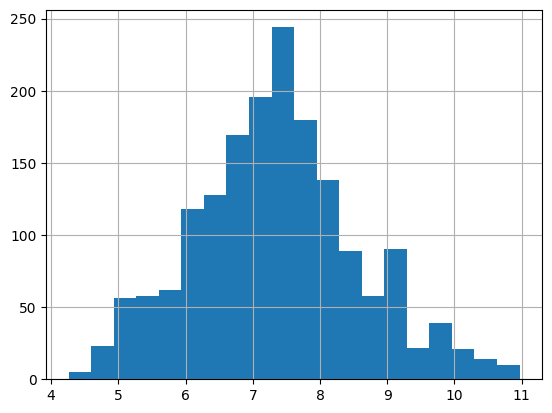

In [22]:
y.hist(bins=20)

*  2) Training set와 test set 분류

> a. sklearn의 train_test_split 함수를 이용
>
> b. Train : test = 8 : 2
>
>
> ※ **주의**, random_state=42 를 고정 시켜 reproduce가 가능한 random 분류를 수행시킨다.

In [23]:
import sklearn.model_selection
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
X_train[:10] #학습용 데이터

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
670,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
798,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1118,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
128,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1228,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [25]:
X_test[:10] #평가용 데이터

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
599,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
135,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
339,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1460,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
240,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1667,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
892,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
y_train[:10]

,pIC50
670,7.04
798,7.25
1710,10.64
1175,7.80
1393,8.30
1118,7.70
128,5.55
514,6.75
1174,7.80
1228,7.92


In [27]:
y_test[:10]

,pIC50
599,6.91
1514,8.87
115,5.52
135,5.58
339,6.32
694,7.07
1460,8.59
240,6.04
1667,9.89
892,7.37


## 9. RandomForest 사용한 회귀예측 수행하기
---

In [28]:
import sklearn.ensemble
from sklearn.ensemble import RandomForestRegressor

* 훈련되지 않은 모델을 선언하고 실제로 학습을 진행한다

In [29]:
my_model = RandomForestRegressor(random_state=42)

In [30]:
%%time
my_model.fit(X_train, y_train)

CPU times: user 19.3 s, sys: 61.5 ms, total: 19.4 s
Wall time: 25.1 s


RandomForestRegressor(random_state=42)

## 10. 모델 평가
---



>1.   test set 정보를 주고 목적값을 예측
2.   predict method 사용





In [31]:
y_pred = my_model.predict(X_test)

In [32]:
y_pred

array([ 7.6237    ,  8.5537    ,  6.6855    ,  5.6659    ,  7.6959    ,
        7.5188    ,  7.7522    ,  7.9563    ,  7.5552    ,  7.526     ,
        7.4467    ,  6.9746    ,  6.4709    ,  6.8383    ,  6.3602    ,
        6.1309    ,  7.6244    ,  6.8821    ,  6.7711    ,  6.9406    ,
        7.8632    ,  7.545     ,  7.9021    ,  7.6239    ,  7.8076    ,
        9.9769    ,  9.9843    ,  8.7784    ,  5.2223    ,  7.4224    ,
        7.4675    ,  7.5617    ,  7.7016    ,  7.2418    ,  6.173     ,
        7.3825    ,  7.7301    ,  8.6126    ,  7.3721    ,  6.1752    ,
        7.2913    ,  8.1991    ,  7.2006    , 10.4017    ,  7.6028    ,
       10.0365    ,  7.2005    ,  7.76905619,  7.3514    ,  7.9184    ,
        6.55      ,  7.1128    ,  7.3406    ,  7.6835    ,  8.4057    ,
        6.9139    , 10.0385    ,  7.0797    ,  7.4436    ,  7.7617    ,
        7.9063    ,  7.2581    , 10.0458    ,  6.8798    ,  6.1418    ,
        8.1912    ,  7.7179    ,  7.6049    ,  8.8122    ,  8.99

* 예측이 잘 되었는지 scatter plot으로 확인

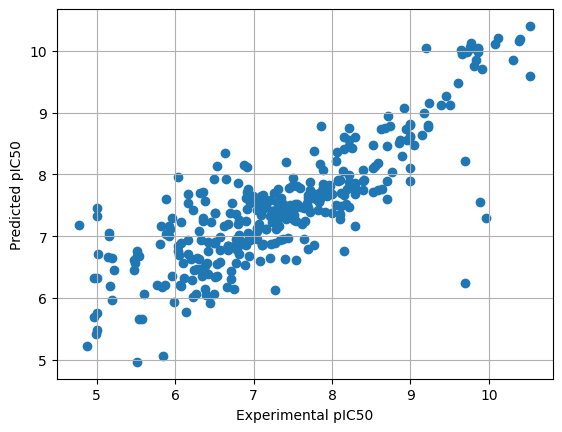

In [33]:
plt.scatter(y_test, y_pred)
plt.xlabel("Experimental pIC50")
plt.ylabel("Predicted pIC50")
plt.grid()

* 기준선 (y==x), 색 변경, 점 크기 등을 조정해보자

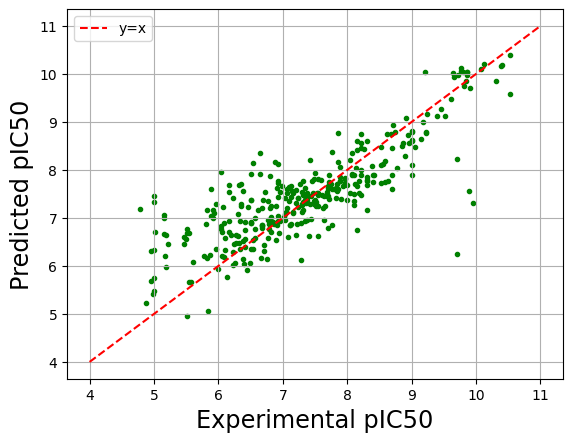

In [34]:
plt.scatter(y_test, y_pred, marker='.', color='green')
plt.xlabel("Experimental pIC50", fontsize='xx-large')
plt.ylabel("Predicted pIC50", fontsize='xx-large')
plt.grid()
plt.plot(range(4, 12), range(4, 12), "r--", label = "y=x")
plt.legend()

* 오차 계산
> #### Mean Sqaured Error (MSE) 사용

* regression에서 가장 많이 사용하는 측정치는 mean squared error 이다.
* 평균 제곱 오차

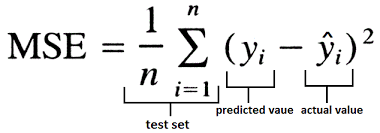

In [35]:
from sklearn.metrics import mean_squared_error

In [36]:
mse1 = mean_squared_error(y_test, y_pred)

In [37]:
print(f"Mean Squared Error of this model is {mse1:.3f} (pIC50 unit)")

Mean Squared Error of this model is 0.500 (pIC50 unit)


* 정확도 분석
> #### Pearson correlation coefficient

<img src="https://editor.analyticsvidhya.com/uploads/39170Formula.JPG" width="500">

In [38]:
np.corrcoef(y_test, y_pred)

array([[1.        , 0.82664452],
       [0.82664452, 1.        ]])

In [39]:
print(f"Pearson's correlation coefficient of our model is {np.corrcoef(y_test,y_pred)[0,1]:.3f}")

Pearson's correlation coefficient of our model is 0.827


최종적으로 우리가 ECFP2 (fp 2048)를 이용해서 학습시킨 모델은 MSE 0.50 pIC50 value (0.69 kcal/mol) 정도의 오차를 가지고, 상관 계수 0.827을 가진다는 것을 확인할 수 있었다.

## 11. 유사한 문제를 classification 문제로 치환하여 풀어보기
---

일반적으로 1~10 $\mu$M 이하의 IC50 값을 가질 때, active한 hit molecule이라고 판단한다.

이번 예제에서 사용하는 데이터에는 낮은 IC50 값을 가지는 분자들이 많으므로 기준을 조금 더 높게 잡아서 0.1 $\mu$M의 IC50 값을 active와 inactive의 기준으로 삼아서 binary classification을 수행하는 모델을 만들어보자.


* 주어진 pIC50 값을 기반으로 pIC50가 7이 넘는 경우 True, 그렇지 않은 경우 False로 변환

In [40]:
y_binary = [t > 7.0 for t in y] # pIC50값이

In [41]:
np.sum(y_binary)

1068

* Active molecule은 1,068개
* 다루기 쉽게 pandas의 Series instance로 변환

In [42]:
y_binary = pd.Series(y_binary)

In [43]:
y_binary.describe()

,0
count,1720
unique,2
top,True
freq,1068


In [44]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y_binary, test_size=0.2, random_state=42)

In [45]:
y_train.head()

,0
670,True
798,True
1710,True
1175,True
1393,True


In [46]:
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
670,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
798,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1710,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1393,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


* RandomForestClassifier 모델 선언

In [47]:
clf = sklearn.ensemble.RandomForestClassifier()

In [48]:
%%time
clf.fit(X_train, y_train)

CPU times: user 1.24 s, sys: 8.9 ms, total: 1.25 s
Wall time: 1.29 s


RandomForestClassifier()

In [49]:
y_pred = clf.predict(X_test)

In [50]:
y_pred

array([ True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True,  True,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True, False, False,  True, False,
       False,  True, False,  True,  True,  True, False, False,  True,
       False,  True,

* 이항 분류기 성능 검증

In [51]:
# accuracy
acc = sklearn.metrics.accuracy_score(y_test, y_pred)
# Recall (sensitivity)
recall = sklearn.metrics.recall_score(y_test, y_pred)
# Precision
prec = sklearn.metrics.precision_score(y_test, y_pred)
print(f"Accuracy:  {acc:.3f}")
print(f"Recall:    {recall:.3f}")
print(f"Precision: {prec:.3f}")

Accuracy:  0.802
Recall:    0.922
Precision: 0.783


---
>F1-score는 precision과 recall의 조화 평균으로 정의된다.
>
>MCC(Matthews correlation coefficient) 값은 -1~1 사이의 값을 가지며, 1에 가까울수록 정확한 예측에 해당한다.

In [52]:
# F1-score
f1=sklearn.metrics.f1_score(y_test, y_pred)

# MCC
mcc=sklearn.metrics.matthews_corrcoef(y_test, y_pred)

In [53]:
print(f"F1-score: {f1:.3f}")
print(f"MCC:      {mcc:.3f}")

F1-score: 0.847
MCC:      0.588


---


> ROC(Receiver operating characteristic) 곡선 그리기

In [54]:
from sklearn.metrics import RocCurveDisplay

<Figure size 1200x1200 with 0 Axes>

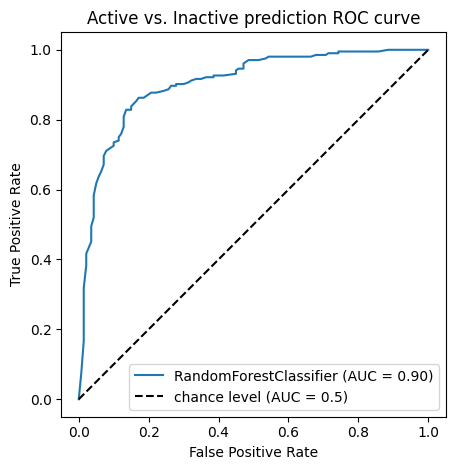

In [55]:
fig=plt.figure(figsize=(12,12))
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Active vs. Inactive prediction ROC curve")
plt.tight_layout()
plt.legend()
plt.show()